## Семинар 3 "Определение ключевых точек лица"

ФИО: Миклин Артем Сергеевич

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


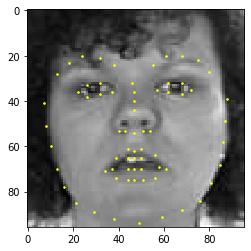

In [47]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, ELU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='yellow', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='y', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, dataframe=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if dataframe is None:
            self.landmarks_frame = pd.read_csv(csv_file)
        else:
            self.landmarks_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks, 'img_name': self.landmarks_frame.iloc[idx, 0]}

        if self.transform:
            sample = self.transform(sample)
#         print(sample['image'].shape)
        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        img_name = sample['img_name']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks),
               'img_name': img_name}

In [74]:
class Mirror_ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        landmarks = np.array([[95-item[0], item[1]] for item in landmarks])
        image = np.flip(image, 1).copy()
        
        img_name = sample['img_name']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks),
               'img_name': img_name}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [84]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=8)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=8)

In [18]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam, train_dataloader=train_dataloader):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [250]:
network = Sequential(Linear(1 * 96 * 96, 200), Tanh(),
               Linear(200, 2 * 68))

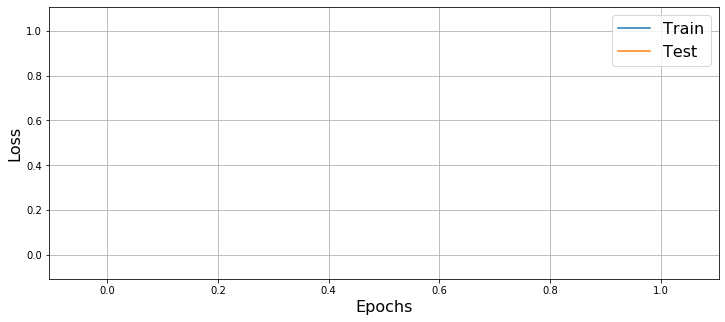

CPU times: user 12 s, sys: 6.93 s, total: 19 s
Wall time: 4.65 s


In [251]:
%%time
train(network, 20, 1e-4)

d1=156, d2=156, d3=156, act=Tanh()


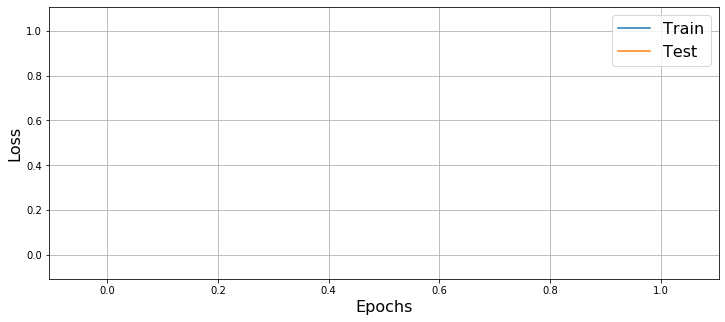

d1=156, d2=156, d3=512, act=Tanh()


Traceback (most recent call last):
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/waffpad/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
   

KeyboardInterrupt: 

In [252]:
%%time
d_inp = 1 * 96 * 96
d_out = 2 * 68

epochs = 10
acts = [Tanh()]
dims1 = [156, 512, 1024]
dims2 = [156, 512, 1024]
dims3 = [156, 512, 1024]

for act in acts:
    for dim1 in dims1:
        for dim2 in dims2:
            for dim3 in dims3:
                net = Sequential(
                          Linear(1 * 96 * 96, dim1),
                          act,
                          Linear(dim1, dim2),
                          act,
                          Linear(dim2, dim3),
                          act,
                          Linear(dim3, 2 * 68)
                       )
                print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
                train(net, epochs, 1e-4)
                

Посмотрев на графики, оставим те параметры, при которых модель еще не "выровнялась", при этом обучилась достаточно хорошо

d1=512, d2=1024, d3=512, act=ELU(alpha=1.0)


Exception ignored in: <function _releaseLock at 0x7f42dad51840>
Traceback (most recent call last):
  File "/home/waffpad/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


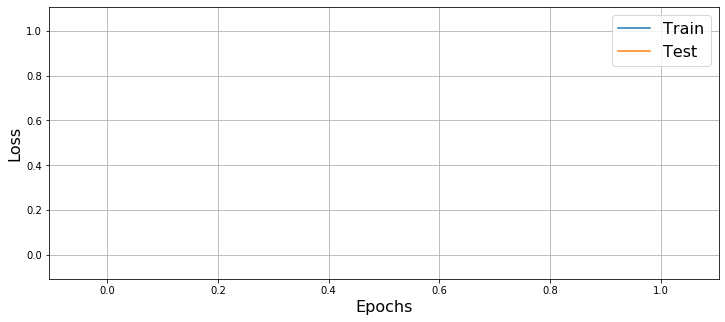

KeyboardInterrupt: 

In [253]:
epochs = 30
act = ELU()
ss = [
#     [156,156,512],
#     [156,512,512],
#     [156,1024,512],
#     [512,156,512],
#     [512,512,512],
    [512,1024,512],
    [1024,156,512],
    [1024,512,512],
    [1024,1024,512]]

for s in ss:
    dim1, dim2, dim3 = s[0], s[1], s[2]
    net = Sequential(
                          Linear(1 * 96 * 96, dim1),
                          act,
                          Linear(dim1, dim2),
                          act,
                          Linear(dim2, dim3),
                          act,
                          Linear(dim3, 2 * 68)
                       )
    print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
    train(net, epochs, 1e-4)

Прервал обучение, т.к. решил, что пока достаточно 20 эпох для выбора модели

In [ ]:
epochs = 20
act = ELU()
ss = [
#     [156,156,512], надо оставить
#     [156,512,512],
#     [156,1024,512],
#     [512,156,512],
#     [512,512,512],
    [512,1024,512],
    [1024,156,512],
    [1024,512,512],
    [1024,1024,512]]

for s in ss:
    dim1, dim2, dim3 = s[0], s[1], s[2]
    net = Sequential(
                          Linear(1 * 96 * 96, dim1),
                          act,
                          Linear(dim1, dim2),
                          act,
                          Linear(dim2, dim3),
                          act,
                          Linear(dim3, 2 * 68)
                       )
    print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
    train(net, epochs, 1e-4)

In [ ]:
epochs = 30
act = ELU()
ss = [
#     [156,156,512], ?
#     [156,512,512],
#     [156,1024,512],
#     [512,156,512],
#     [512,512,512],
#     [512,1024,512],надо оставить
    [1024,156,512],
#     [1024,512,512],
    [1024,1024,512]]

for s in ss:
    dim1, dim2, dim3 = s[0], s[1], s[2]
    net = Sequential(
                          Linear(1 * 96 * 96, dim1),
                          act,
                          Linear(dim1, dim2),
                          act,
                          Linear(dim2, dim3),
                          act,
                          Linear(dim3, 2 * 68)
                       )
    print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
    train(net, epochs, 1e-4)

In [ ]:
epochs = 40
acts = [ELU(), Tanh()]
lrs = [1e-4,1e-2]
ss = [[1024,1024,512]]

for lr in lrs:
    for act in acts:
        for s in ss:
            dim1, dim2, dim3 = s[0], s[1], s[2]
            net = Sequential(
                                  Linear(1 * 96 * 96, dim1),
                                  act,
                                  Linear(dim1, dim2),
                                  act,
                                  Linear(dim2, dim3),
                                  act,
                                  Linear(dim3, 2 * 68)
                               )
            print("d1={}, d2={}, d3={}, act={}, lr={}".format(dim1,dim2,dim3,act,lr))
            train(net, epochs, lr)

In [ ]:
%%time
epochs = 50
act = ELU()
ss = [
#     [156,156,512], ?
#     [156,512,512],
#     [156,1024,512],
#     [512,156,512],
#     [512,512,512],
#     [512,1024,512],
#     [1024,156,512],
#     [1024,512,512],
    [1024,1024,512]]

for s in ss:
    dim1, dim2, dim3 = s[0], s[1], s[2]
    net = Sequential(
                          Linear(1 * 96 * 96, dim1),
                          act,
                          Linear(dim1, dim2),
                          act,
                          Linear(dim2, dim3),
                          act,
                          Linear(dim3, 2 * 68)
                       )
    print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
    train(net, epochs, 1e-4)

In [ ]:
best_network = net

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=8)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = best_network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)

In [48]:
def plot_landmarked_image(n, flip = False):
    img_name = landmarks_frame.ix[n, 0]
    landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)
    if flip:
        landmarks = np.array([[95-item[0], item[1]] for item in landmarks])
#     landmarks = np.array([[item[0], item[1]] for item in landmarks])

#     print('Image name: {}'.format(img_name))
#     print('Landmarks shape: {}'.format(landmarks.shape))
#     print('First 4 Landmarks: {}'.format(landmarks[:4]))

    def show_landmarks(image, landmarks):
        """Show image with landmarks"""
        plt.imshow(image, cmap='gray')
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='yellow', cmap='rgb')
        plt.pause(0.001)  

    plt.figure(figsize=(8,8))
    image = io.imread(os.path.join('dataset/train/', img_name))
    image = np.asarray(image)
    if flip:
        image = np.flip(image, 1)
    show_landmarks(image,
                   landmarks)
    plt.show()

## Анализ ошибок

Посмотрим на картинки, соответствующие самым большим ошибкам

In [ ]:
%%time
root_dir='dataset/train'
err_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=8)
loss=MSELoss()
losses = []
for sample in err_dataloader:
    
    X = sample['image']
    X = X.view(X.shape[0], -1).type(dtype)
    y = sample['landmarks']
    y = y.view(y.shape[0], -1).type(dtype)

    prediction = best_network(X)
    loss_batch = loss(prediction, y)
    losses.append((loss_batch.item(), sample['img_name']))

In [ ]:
losses.sort(reverse=True)
losses

In [10]:
def plot_landmarked_image_by_name(name):
    lf = landmarks_frame[landmarks_frame.image_name == name]
    n = 0
    img_name = lf.iloc[0,0]
    landmarks = lf.iloc[0,1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)

    def show_landmarks(image, landmarks):
        """Show image with landmarks"""
        plt.imshow(image, cmap='gray')
        plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='yellow', cmap='rgb')
        plt.pause(0.001)  
        
    print(img_name)
    
    plt.figure()
    show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
                   landmarks)
    plt.show()

In [11]:
for item in losses[4:9]:
    plot_landmarked_image_by_name(item[1][0])

NameError: name 'losses' is not defined

Я выбрал некоторые среди 500 самых плохих

57
2080.jpeg


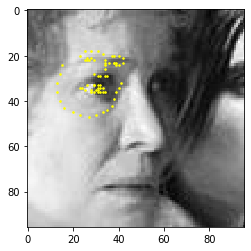

4140.jpeg


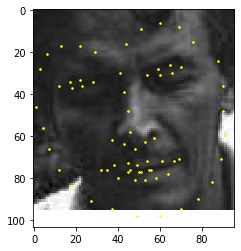

4828.jpeg


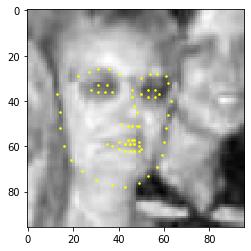

1958.jpeg


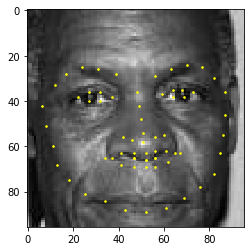

2951.jpeg


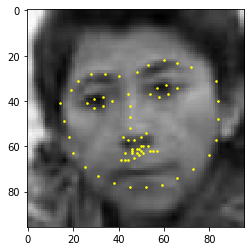

1953.jpeg


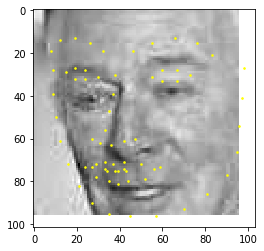

4990.jpeg


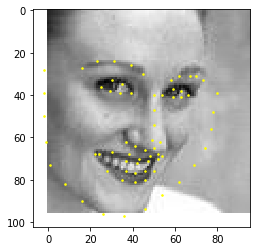

6394.jpeg


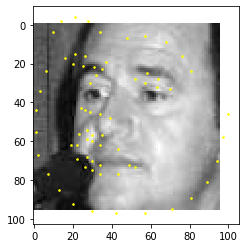

6428.jpeg


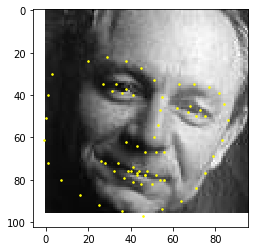

6253.jpeg


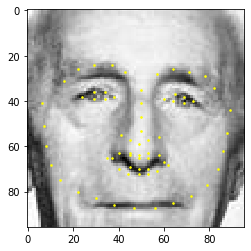

3885.jpeg


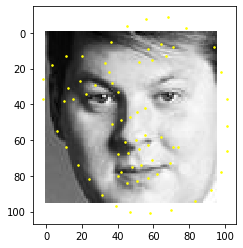

5198.jpeg


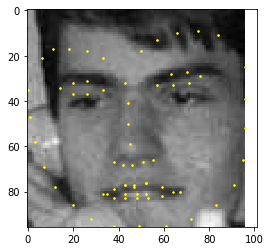

467.jpeg


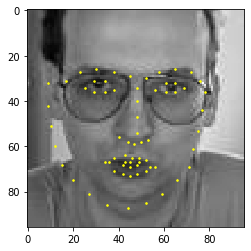

5167.jpeg


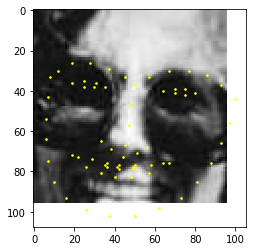

1622.jpeg


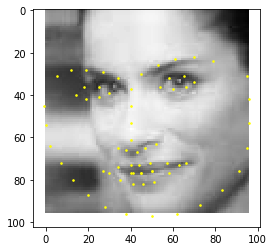

4288.jpeg


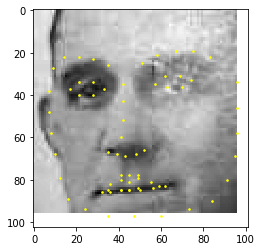

6082.jpeg


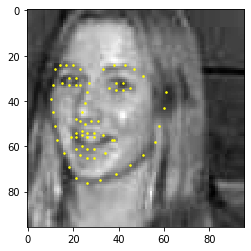

6965.jpeg


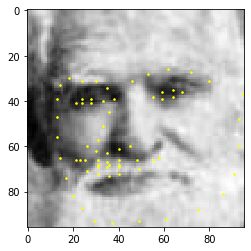

2789.jpeg


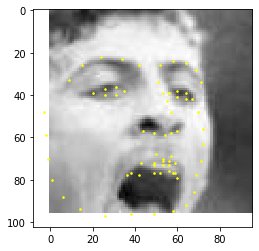

2350.jpeg


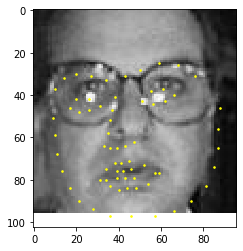

6627.jpeg


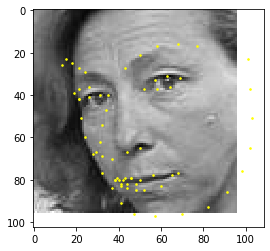

3287.jpeg


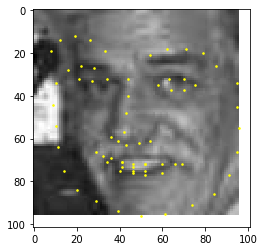

6806.jpeg


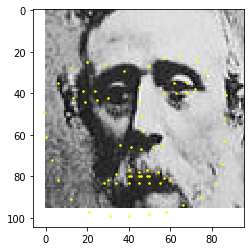

2002.jpeg


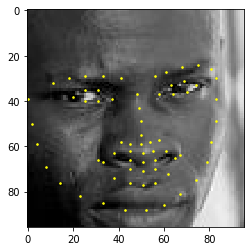

4710.jpeg


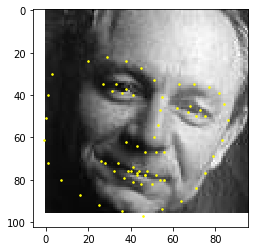

6978.jpeg


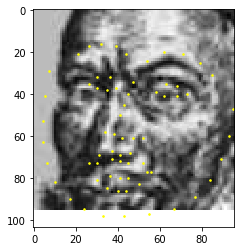

4180.jpeg


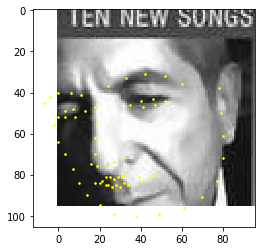

4371.jpeg


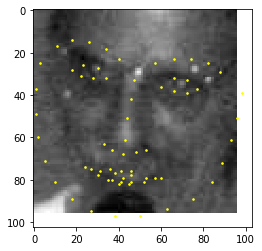

6004.jpeg


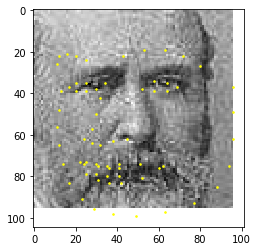

4620.jpeg


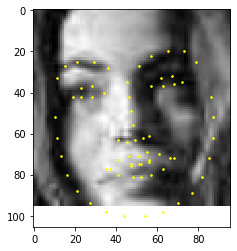

2764.jpeg


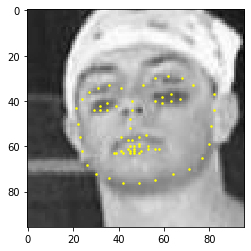

4275.jpeg


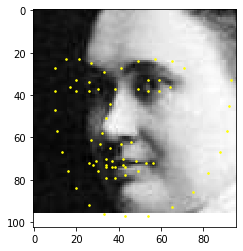

1260.jpeg


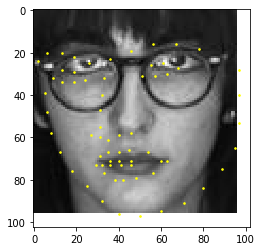

5958.jpeg


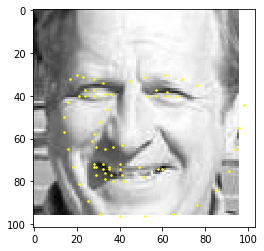

6301.jpeg


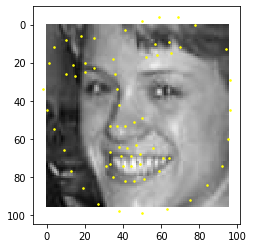

6728.jpeg


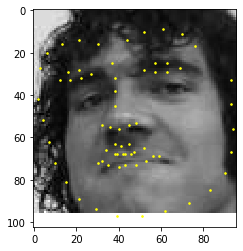

5890.jpeg


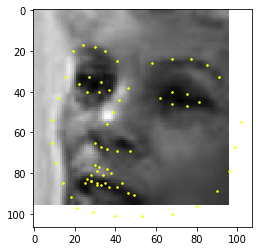

3527.jpeg


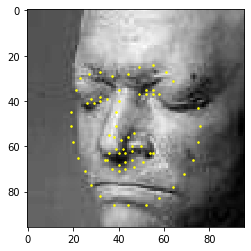

2890.jpeg


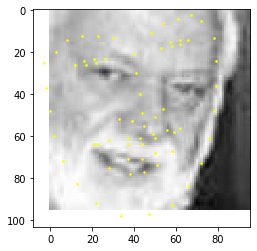

4345.jpeg


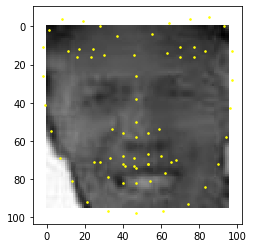

5632.jpeg


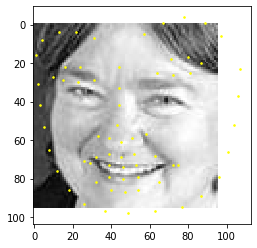

6102.jpeg


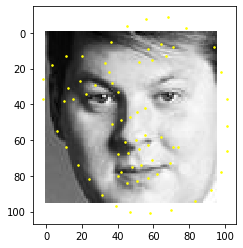

5968.jpeg


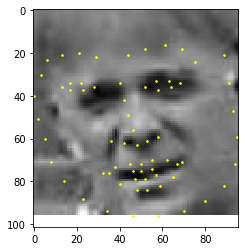

2557.jpeg


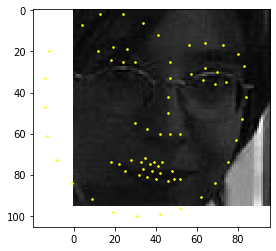

2222.jpeg


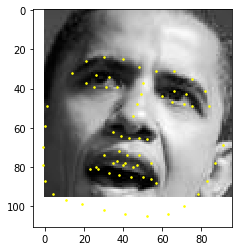

1992.jpeg


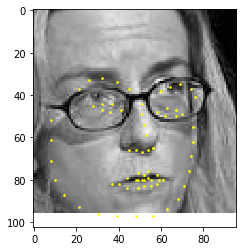

2871.jpeg


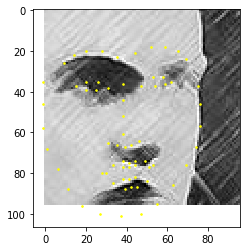

6565.jpeg


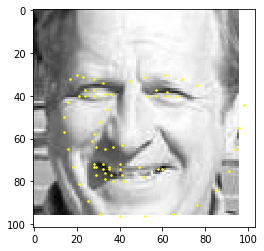

6880.jpeg


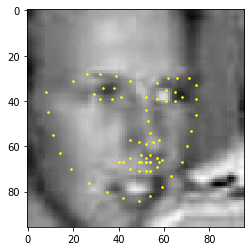

5093.jpeg


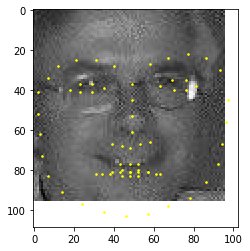

1861.jpeg


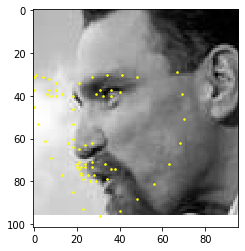

3497.jpeg


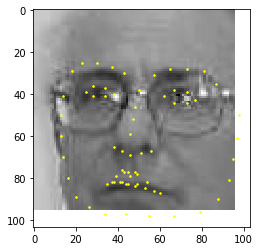

437.jpeg


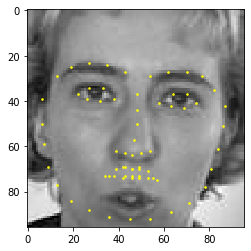

5614.jpeg


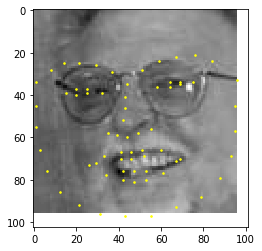

5370.jpeg


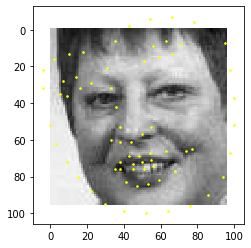

3961.jpeg


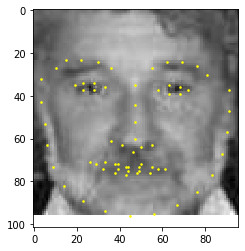

3670.jpeg


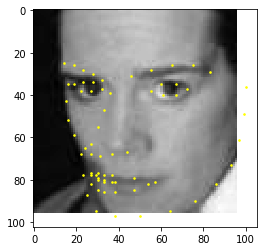

In [49]:
bad_landmarks = ["5632.jpeg", "2890.jpeg", "2080.jpeg", "2350.jpeg", "5198.jpeg", "1992.jpeg", "4140.jpeg", "3670.jpeg", "1260.jpeg", "3527.jpeg", "5968.jpeg", "6880.jpeg", "1953.jpeg", "2871.jpeg", "4180.jpeg", "6253.jpeg", "6965.jpeg", "4828.jpeg", "2764.jpeg", "5890.jpeg", "6004.jpeg", "2557.jpeg", "1861.jpeg", "2890.jpeg", "6394.jpeg", "6301.jpeg", "6082.jpeg", "5370.jpeg", "4345.jpeg", "6102.jpeg", "3885.jpeg", "6728.jpeg", "4371.jpeg", "1958.jpeg", "5093.jpeg", "6806.jpeg", "5614.jpeg", "1622.jpeg", "2951.jpeg", "2002.jpeg", "2789.jpeg", "2222.jpeg", "437.jpeg", "4288.jpeg", "5167.jpeg", "6627.jpeg", "4990.jpeg", "3287.jpeg", "4275.jpeg", "4620.jpeg", "3961.jpeg", "6565.jpeg", "5958.jpeg", "6428.jpeg", "4710.jpeg", "3497.jpeg", "6978.jpeg", "467.jpeg"]
bad_landmarks = set(bad_landmarks)
print(len(bad_landmarks))
for name in bad_landmarks:
    plot_landmarked_image_by_name(name)

In [31]:
clean_landmarks_frame = landmarks_frame.copy()
clean_landmarks_frame = clean_landmarks_frame.set_index("image_name")
clean_landmarks_frame.shape

(6221, 136)

In [32]:
for name in bad_landmarks:
    clean_landmarks_frame.drop(name, axis=0, inplace=True)

In [33]:
clean_landmarks_frame.shape

(6164, 136)

In [37]:
clean_landmarks_frame = clean_landmarks_frame.reset_index()

In [24]:
# clean_landmarks_frame = clean_landmarks_frame.set_index([pd.Index(np.arange(clean_landmarks_frame.shape[0]))])

In [44]:
clean_landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0.jpeg,10,43,9,53,8,64,8,74,10,...,47,78,56,80,47,77,43,77,39,77
1,1.jpeg,9,32,8,42,9,52,12,62,15,...,48,74,53,76,48,77,46,77,42,77
2,10.jpeg,4,34,5,44,6,54,9,64,14,...,50,70,56,72,50,72,47,72,43,72
3,100.jpeg,12,41,13,51,15,60,17,70,21,...,54,72,61,71,54,73,51,73,47,73
4,1000.jpeg,8,46,9,55,10,64,12,73,16,...,54,65,62,70,54,72,50,72,46,71


In [45]:
clean_train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor(),
                                     dataframe = clean_landmarks_frame
                                     )

In [41]:
clean_train_dataloader = DataLoader(clean_train_dataset, batch_size=64,
                        shuffle=True, num_workers=8)

d1=1024, d2=1024, d3=512, act=ELU(alpha=1.0)
Epoch 49... (Train/Test) MSE: 4.261/7.483788

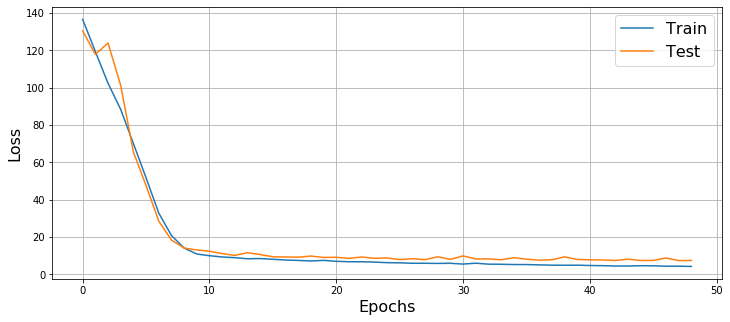

CPU times: user 1h 5min 20s, sys: 32min 9s, total: 1h 37min 29s
Wall time: 15min 17s


In [46]:
%%time
epochs = 50
act = ELU()
s = [1024,1024,512]
dim1, dim2, dim3 = s[0], s[1], s[2]

clean_net = Sequential(
                      Linear(1 * 96 * 96, dim1),
                      act,
                      Linear(dim1, dim2),
                      act,
                      Linear(dim2, dim3),
                      act,
                      Linear(dim3, 2 * 68)
                   )
print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
train(clean_net, epochs, 1e-4, train_dataloader=clean_train_dataloader)

0


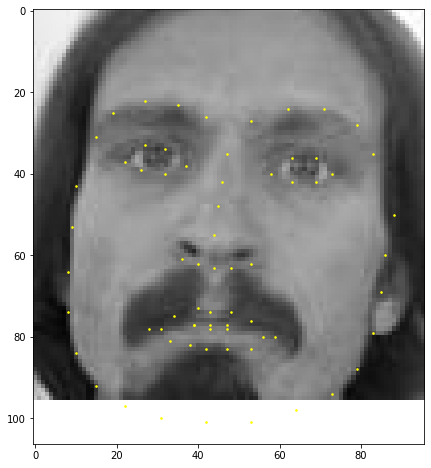

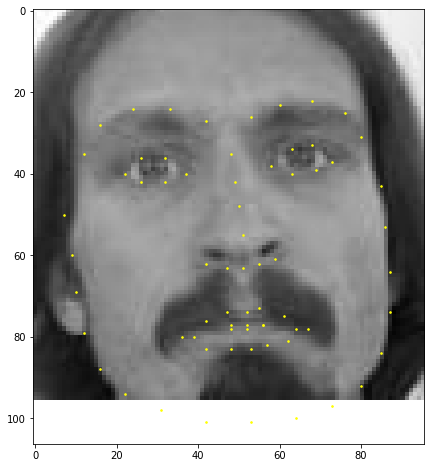

In [85]:
for i in range(1):
    print(i)
    plot_landmarked_image(i)
    plot_landmarked_image(i, flip=True)

In [75]:
mirr_clean_train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=Mirror_ToTensor(),
                                     dataframe = clean_landmarks_frame
                                     )

In [76]:
from torch.utils.data import ConcatDataset

In [77]:
comb_train_dataset = ConcatDataset([clean_train_dataset, mirr_clean_train_dataset])

In [78]:
comb_train_dataloader = DataLoader(comb_train_dataset, batch_size=64,
                        shuffle=True, num_workers=8)

d1=1024, d2=1024, d3=512, act=ELU(alpha=1.0)
Epoch 34... (Train/Test) MSE: 152.065/122.890

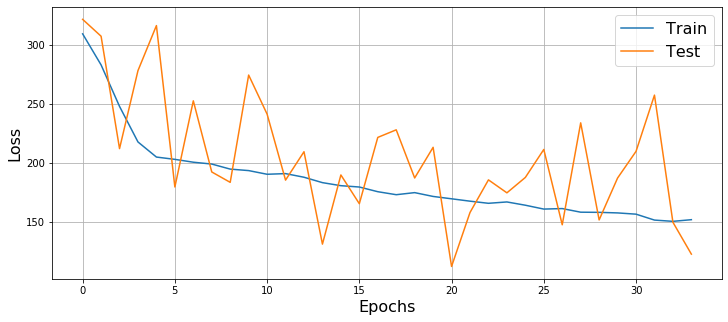

CPU times: user 1h 30min 24s, sys: 44min 7s, total: 2h 14min 31s
Wall time: 20min 23s


In [79]:
%%time
epochs = 35
act = ELU()
s = [1024,1024,512]
dim1, dim2, dim3 = s[0], s[1], s[2]

clean_net = Sequential(
                      Linear(1 * 96 * 96, dim1),
                      act,
                      Linear(dim1, dim2),
                      act,
                      Linear(dim2, dim3),
                      act,
                      Linear(dim3, 2 * 68)
                   )
print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
train(clean_net, epochs, 1e-4, train_dataloader=comb_train_dataloader)

d1=1024, d2=1024, d3=512, act=ELU(alpha=1.0)
Epoch 9... (Train/Test) MSE: 128.681/253.084

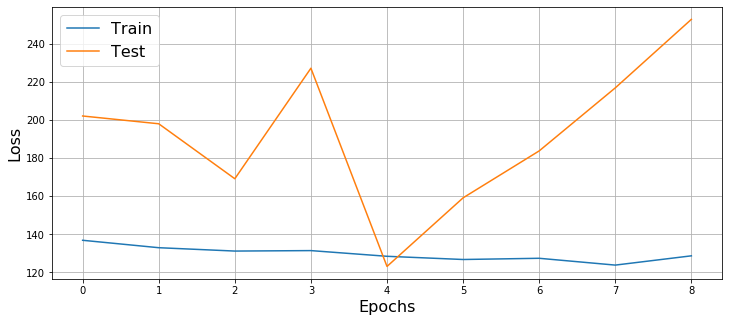

CPU times: user 23min 25s, sys: 11min 32s, total: 34min 57s
Wall time: 5min 19s


In [86]:
%%time
epochs = 10
print("d1={}, d2={}, d3={}, act={}".format(dim1,dim2,dim3,act))
train(clean_net, epochs, 1e-4, train_dataloader=comb_train_dataloader)

In [83]:
test_dataloader

10